Importing Libraries

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from spacy import load
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Loading Data

In [10]:
path = "C:/Users/user/Downloads/DiceyTechHack"
data  = pd.read_csv(path +"/LinkedInData.csv",encoding="utf-8")

Data Familirization

In [11]:
data.head(2)

,Date,Content Type,Sent by,Post,Impressions,Organic Impressions,Engagement Rate (per Impression),Engagements,Reactions,Likes,Comments,Shares,Click-Through Rate,Post Link Clicks,Post Clicks (All),Video Views,Organic Video Views,Tags
0,7/13/2023 12:03,Photo,Blessing Ubah,Your money should not be a gamble. Before you ...,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,CIB Posts
1,7/12/2023 20:00,Text,Blessing Ubah,"What skill (s) do you have, that no one ever t...",0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,Other


Data Preprocessing

In [12]:
data["Date"] = pd.to_datetime(data["Date"])
data["PostHour"] = data["Date"].dt.hour
data["PostMonth"] = data["Date"].dt.month_name()
data["PostYear"] = data["Date"].dt.year

Sentiment, topic and entity recognition

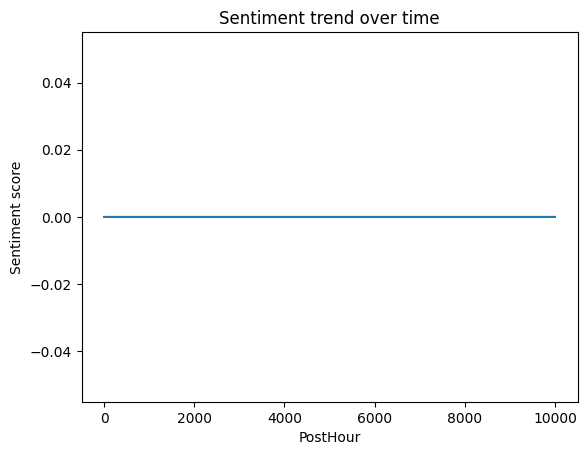

In [13]:
import re
df = pd.read_csv(path + '/InstagramData.csv', usecols=["Post"])

# Convert the 'Post' column to strings
df['Post'] = df['Post'].astype(str)

# Perform sentiment analysis
sentiment_analyzer = SentimentIntensityAnalyzer()
sentiment_scores = []
for post in df['Post']:
    sentiment_score = sentiment_analyzer.polarity_scores(post)['compound']
    sentiment_scores.append(int(sentiment_score))

df['sentiment_score'] = sentiment_scores

# Perform topic modeling
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['Post'])

lda = LatentDirichletAllocation(n_components=10)
lda_model = lda.fit(X)

topics = lda_model.components_
topic_names = ['Topic {}'.format(i) for i in range(len(topics))]

df['topic'] = lda_model.transform(X).argmax(axis=1)

# Perform entity recognition
nlp = load('en_core_web_sm')
entities = []
for post in df['Post']:
    doc = nlp(post)
    entities.append([entity.text for entity in doc.ents])

df['entities'] = entities

# Perform keyword analysis
keywords = []
for post in df['Post']:
    words = re.split(r'\W', post.lower())
    keywords.append(Counter(words).most_common(10))

df['keywords'] = keywords

# Identify trends
plt.plot(df['sentiment_score'])
plt.xlabel('PostHour')
plt.ylabel('Sentiment score')
plt.title('Sentiment trend over time')
plt.show()

In [14]:
data["Topic"] = df["topic"]
data["Entities"] = df["entities"]
data["Keywords"] = df["keywords"]

Text Analysis - Word Cloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


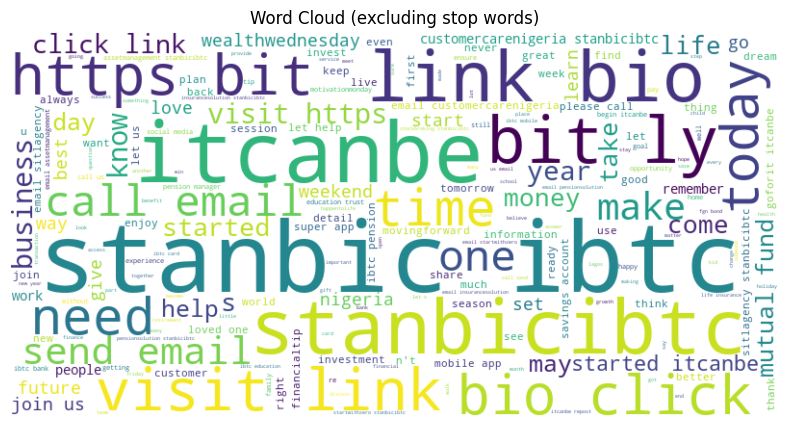

In [15]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
nltk.download('punkt')

all_text = ' '.join(df['Post'])

# Tokenize the text
tokens = word_tokenize(all_text)

# Removing stopwords
stop_words = set(stopwords.words('english'))
filtered_tokens = [word.lower() for word in tokens if word.lower() not in stop_words]

filtered_text = ' '.join(filtered_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_text)

# Plotting the WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud (excluding stop words)')
plt.show()

In [16]:
data.columns

Index(['Date', 'Content Type', 'Sent by', 'Post', 'Impressions',
       'Organic Impressions', 'Engagement Rate (per Impression)',
       'Engagements', 'Reactions', 'Likes', 'Comments', 'Shares',
       'Click-Through Rate', 'Post Link Clicks', 'Post Clicks (All)',
       'Video Views', 'Organic Video Views', 'Tags', 'PostHour', 'PostMonth',
       'PostYear', 'Topic', 'Entities', 'Keywords'],
      dtype='object')

Content Analysis

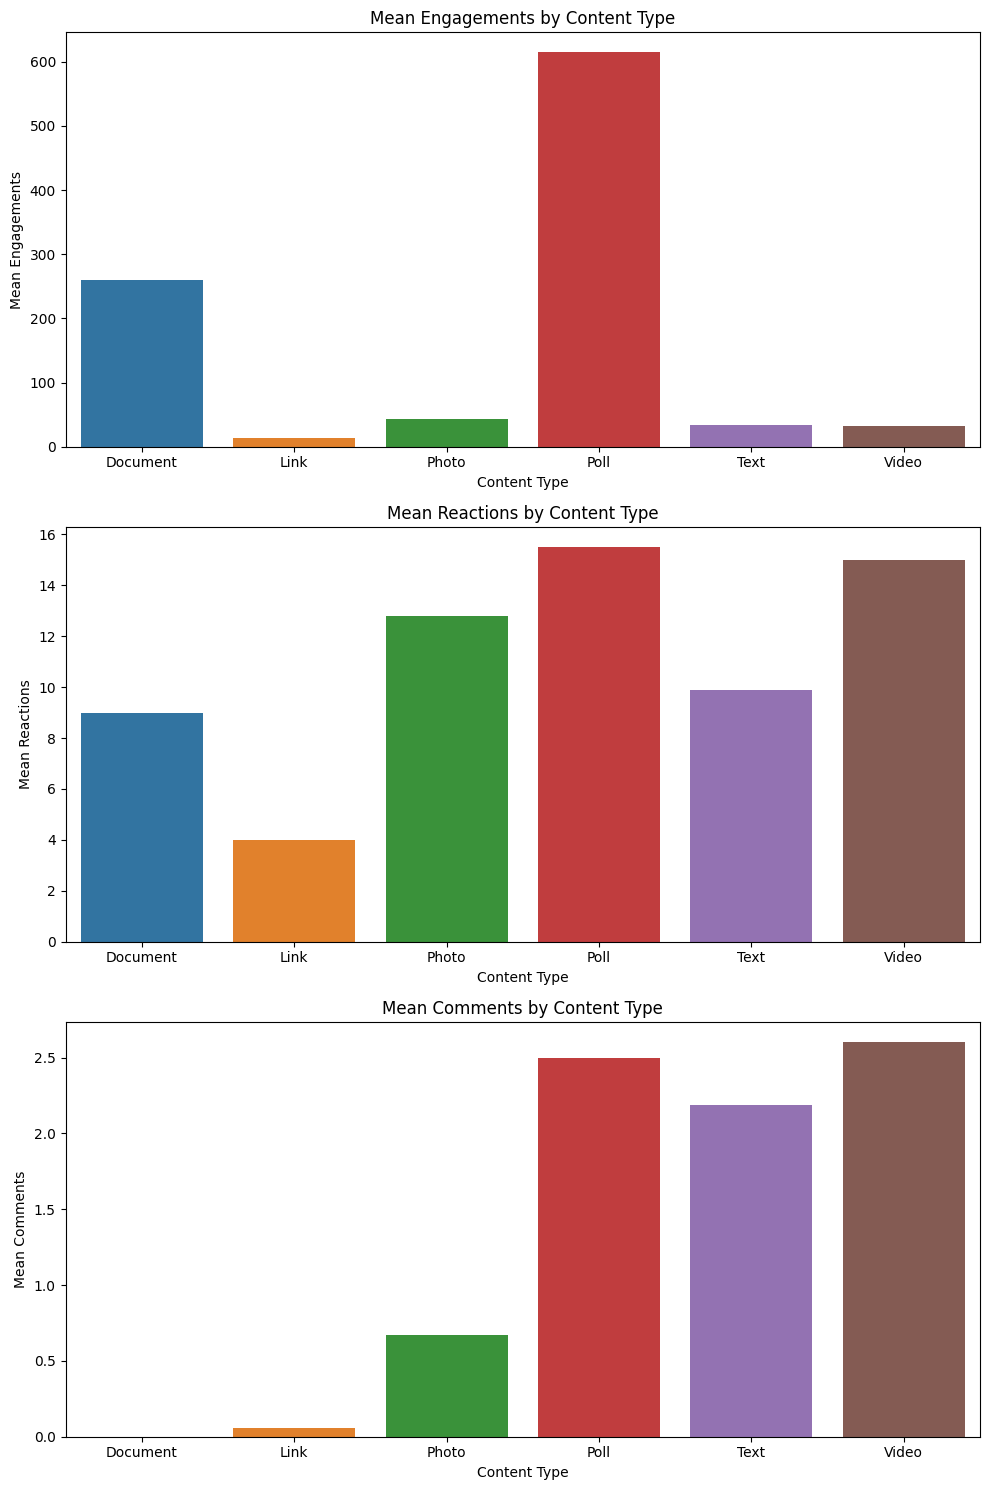

In [17]:
engagement_by_content_type = data.groupby('Content Type')[['Engagements', 'Reactions', 'Comments']].mean().reset_index()

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 15))

sns.barplot(data=engagement_by_content_type, x='Content Type', y='Engagements', ax=axes[0])
axes[0].set_xlabel('Content Type')
axes[0].set_ylabel('Mean Engagements')
axes[0].set_title('Mean Engagements by Content Type')

sns.barplot(data=engagement_by_content_type, x='Content Type', y='Reactions', ax=axes[1])
axes[1].set_xlabel('Content Type')
axes[1].set_ylabel('Mean Reactions')
axes[1].set_title('Mean Reactions by Content Type')

sns.barplot(data=engagement_by_content_type, x='Content Type', y='Comments', ax=axes[2])
axes[2].set_xlabel('Content Type')
axes[2].set_ylabel('Mean Comments')
axes[2].set_title('Mean Comments by Content Type')

plt.tight_layout()
plt.show()

Sent By Analysis

Text(0.5, 1.0, 'Engagements by Sent by')

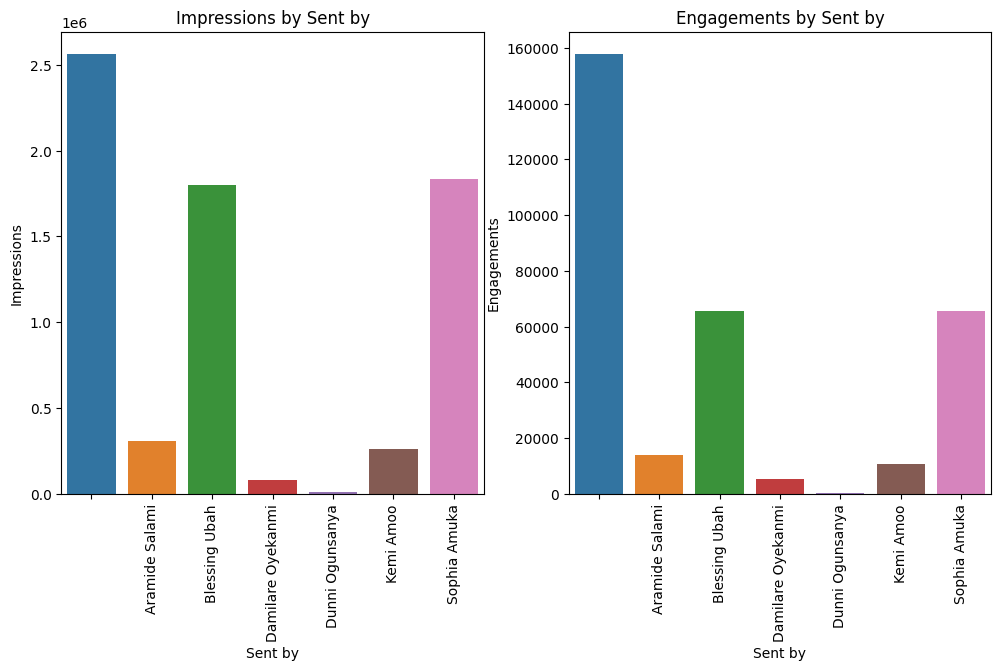

In [18]:
sent_by_data = data.groupby('Sent by').sum().reset_index()

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
sns.barplot(x = "Sent by", y = "Impressions",data = sent_by_data)
plt.xticks(rotation=90)
plt.title("Impressions by Sent by")

plt.subplot(1,2,2)
sns.barplot(x = "Sent by", y = "Engagements",data = sent_by_data)
plt.xticks(rotation=90)
plt.title("Engagements by Sent by")

Engagement Rate Analysis

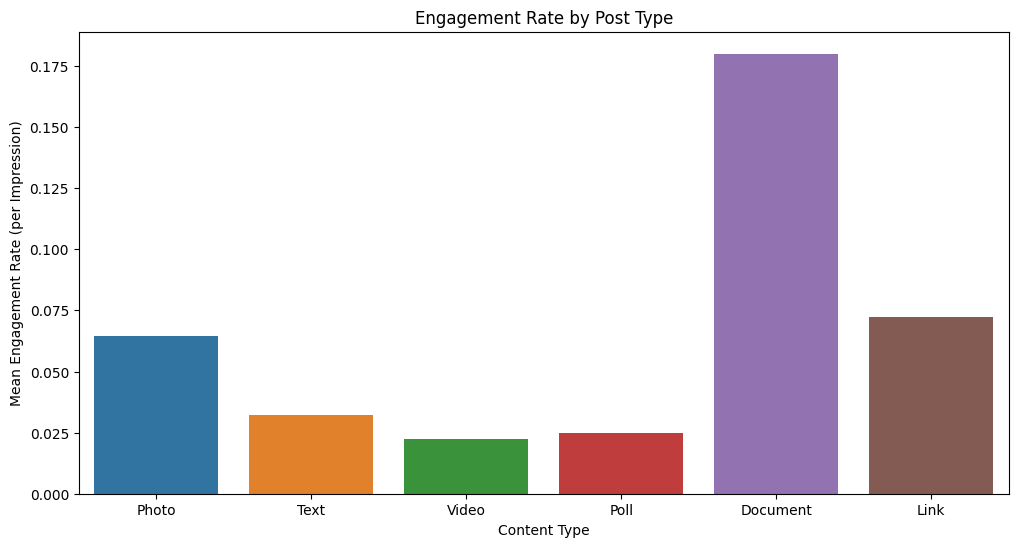

In [19]:
#Engagement Rate Analysis
plt.figure(figsize=(12, 6))
sns.barplot(data=data, x='Content Type', y='Engagement Rate (per Impression)', ci=None)
plt.xlabel('Content Type')
plt.ylabel('Mean Engagement Rate (per Impression)')
plt.title('Engagement Rate by Post Type')
plt.show()

Hourly Analysis

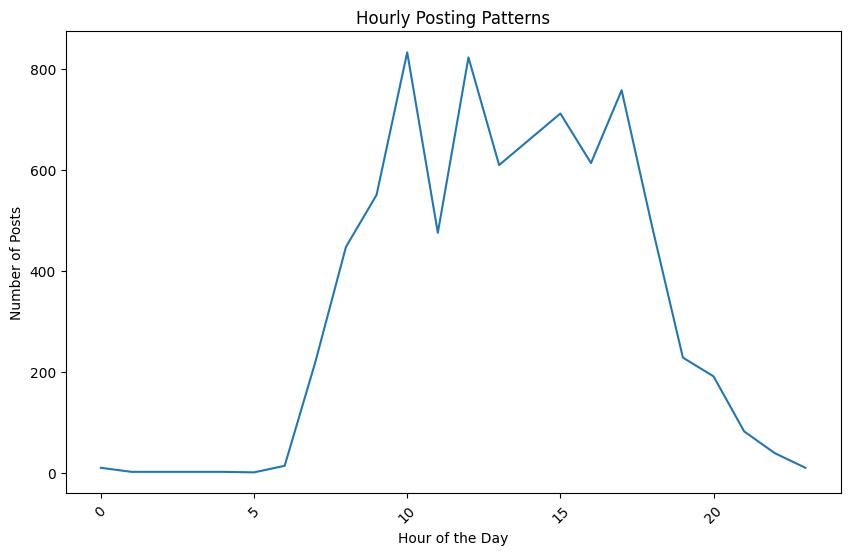

In [20]:
hourly_posting = data['PostHour'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.lineplot(x=hourly_posting.index, y=hourly_posting.values)
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Posts')
plt.title('Hourly Posting Patterns')
plt.xticks(rotation=45)
plt.show()

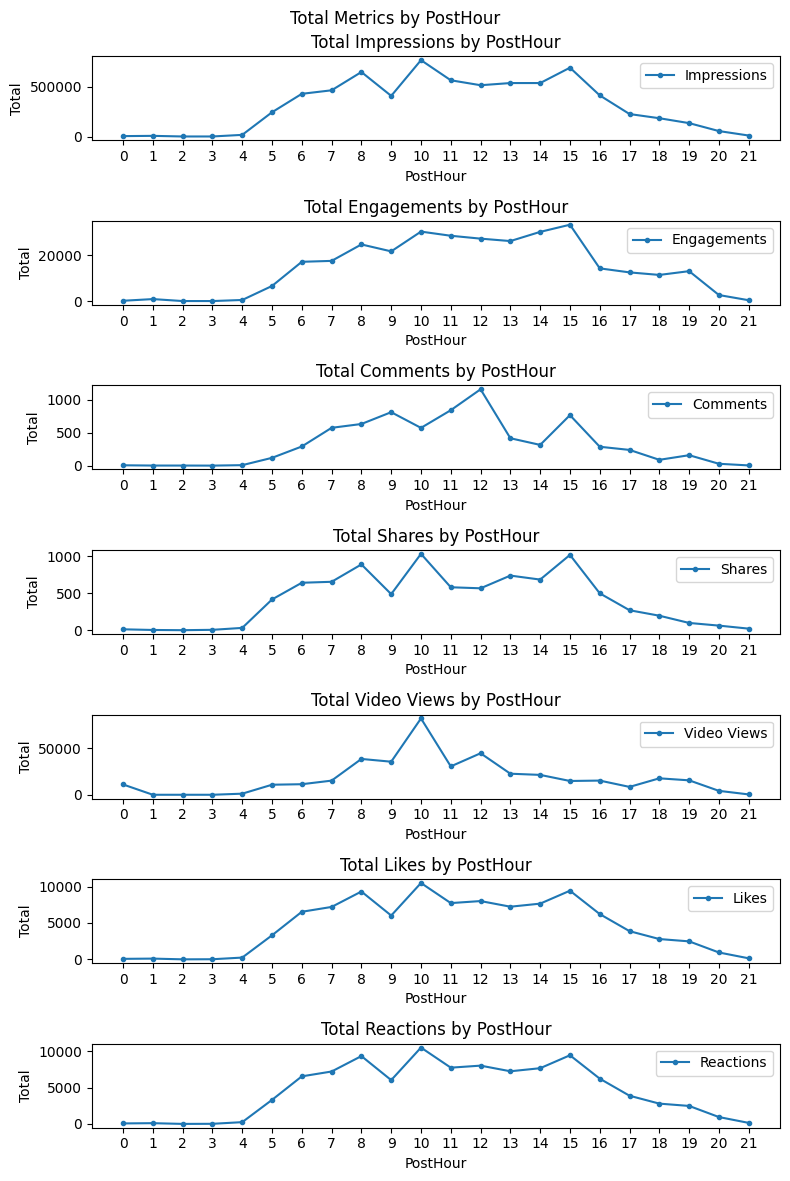

In [21]:
grouped_data = data.groupby('PostHour')[['Impressions', 'Engagements','Comments','Shares','Video Views','Likes', 'Reactions']].sum()

hours = list(range(24))
hours = hours[:-2]

sorted_data = grouped_data.sort_values(by='PostHour')

fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(8, 12))

plt.subplots_adjust(hspace=0.5)

for i, metric in enumerate(['Impressions', 'Engagements','Comments','Shares','Video Views','Likes', 'Reactions']):
    ax = axes[i]

    ax.plot(hours, sorted_data[metric], label=metric, marker='.')

    ax.set_title(f'Total {metric} by PostHour')
    ax.set_xlabel('PostHour')
    ax.set_ylabel('Total')

    ax.set_xticks(hours)
    ax.legend()

fig.suptitle('Total Metrics by PostHour')

plt.tight_layout()

plt.show()

Top 5 Performing Years

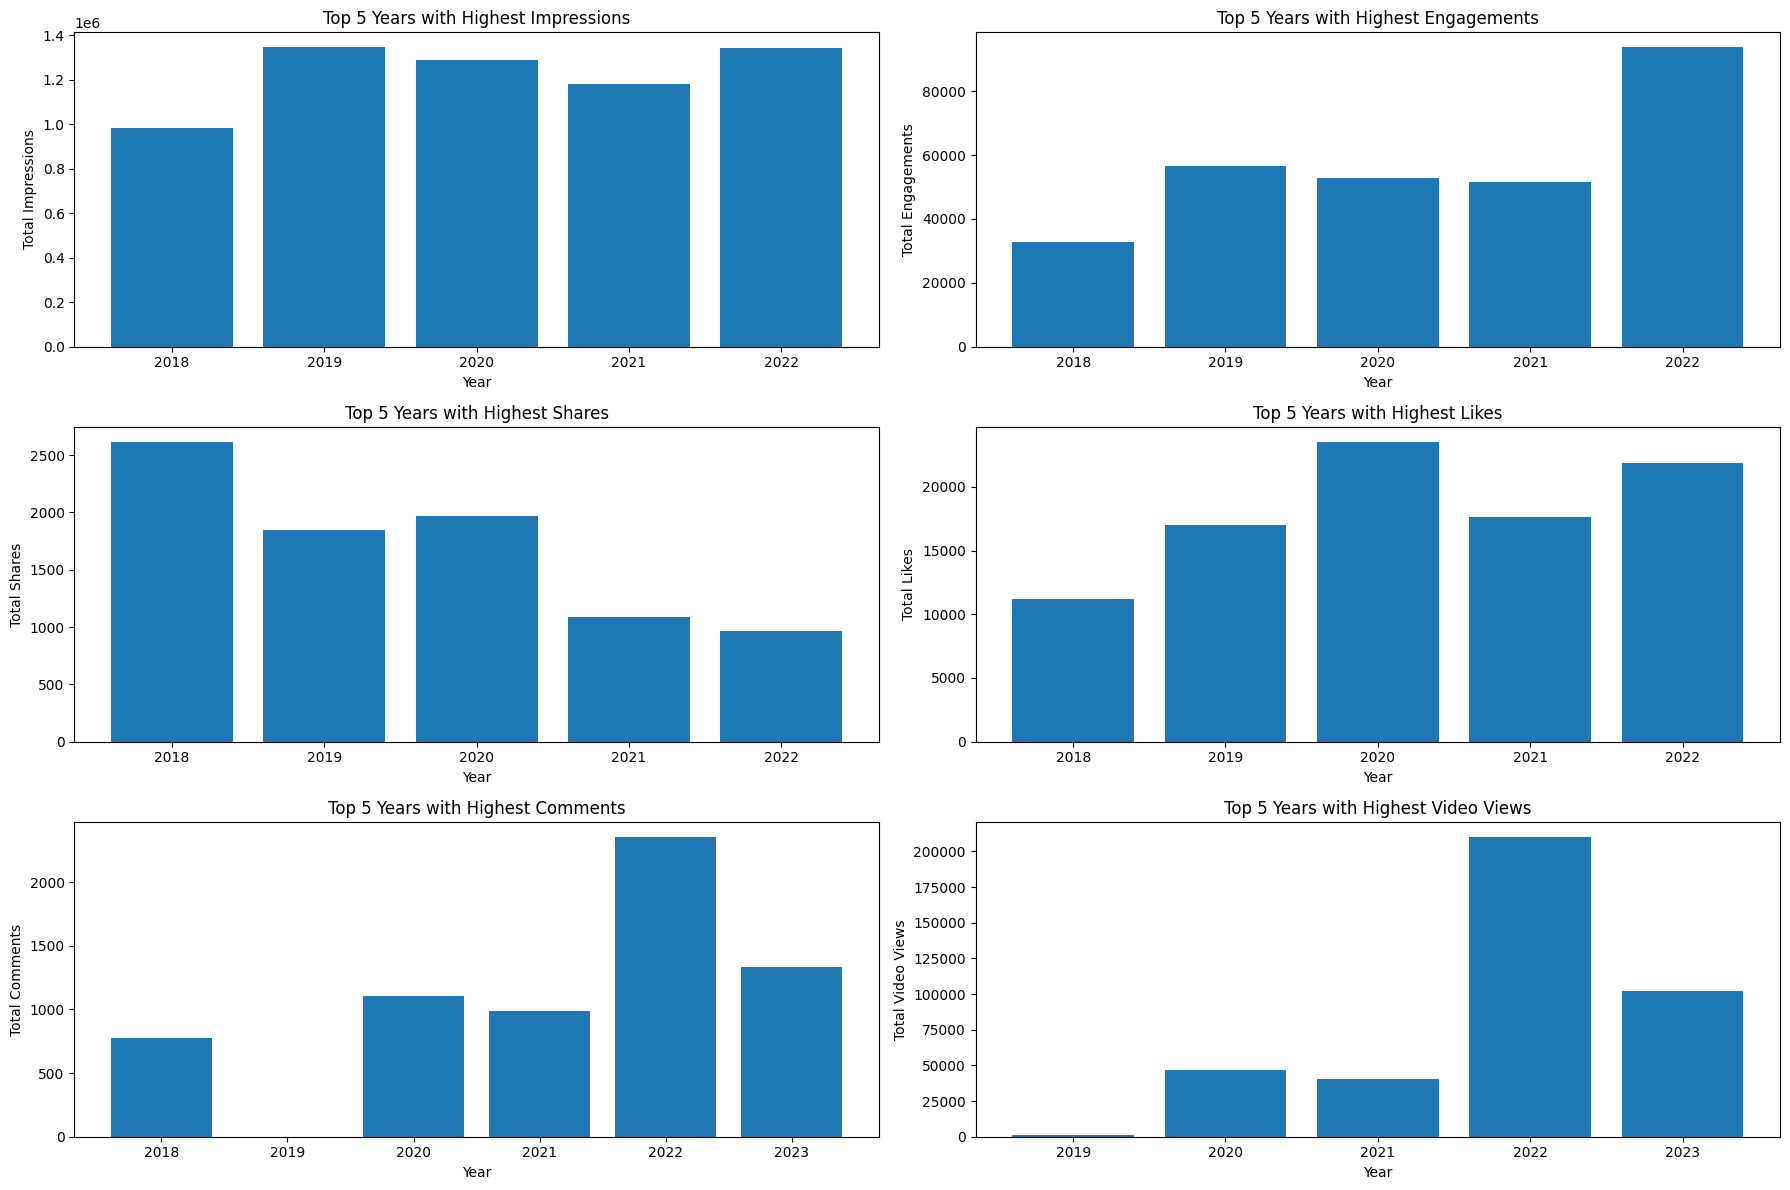

In [22]:
yearly_data = data.groupby('PostYear')[['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']].sum()

sorted_yearly_data = {}
for metric in ['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']:
    sorted_yearly_data[metric] = yearly_data.sort_values(by=metric, ascending=False)

top_5_years = {}
for metric in ['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']:
    top_5_years[metric] = sorted_yearly_data[metric].head(5)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

for i, metric in enumerate(['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']):
    ax = axes[i // 2, i % 2]
    ax.bar(top_5_years[metric].index, top_5_years[metric][metric])
    ax.set_title(f'Top 5 Years with Highest {metric}')
    ax.set_xlabel('Year')
    ax.set_ylabel(f'Total {metric}')

plt.tight_layout()

plt.show()

Top 5 Performing Months

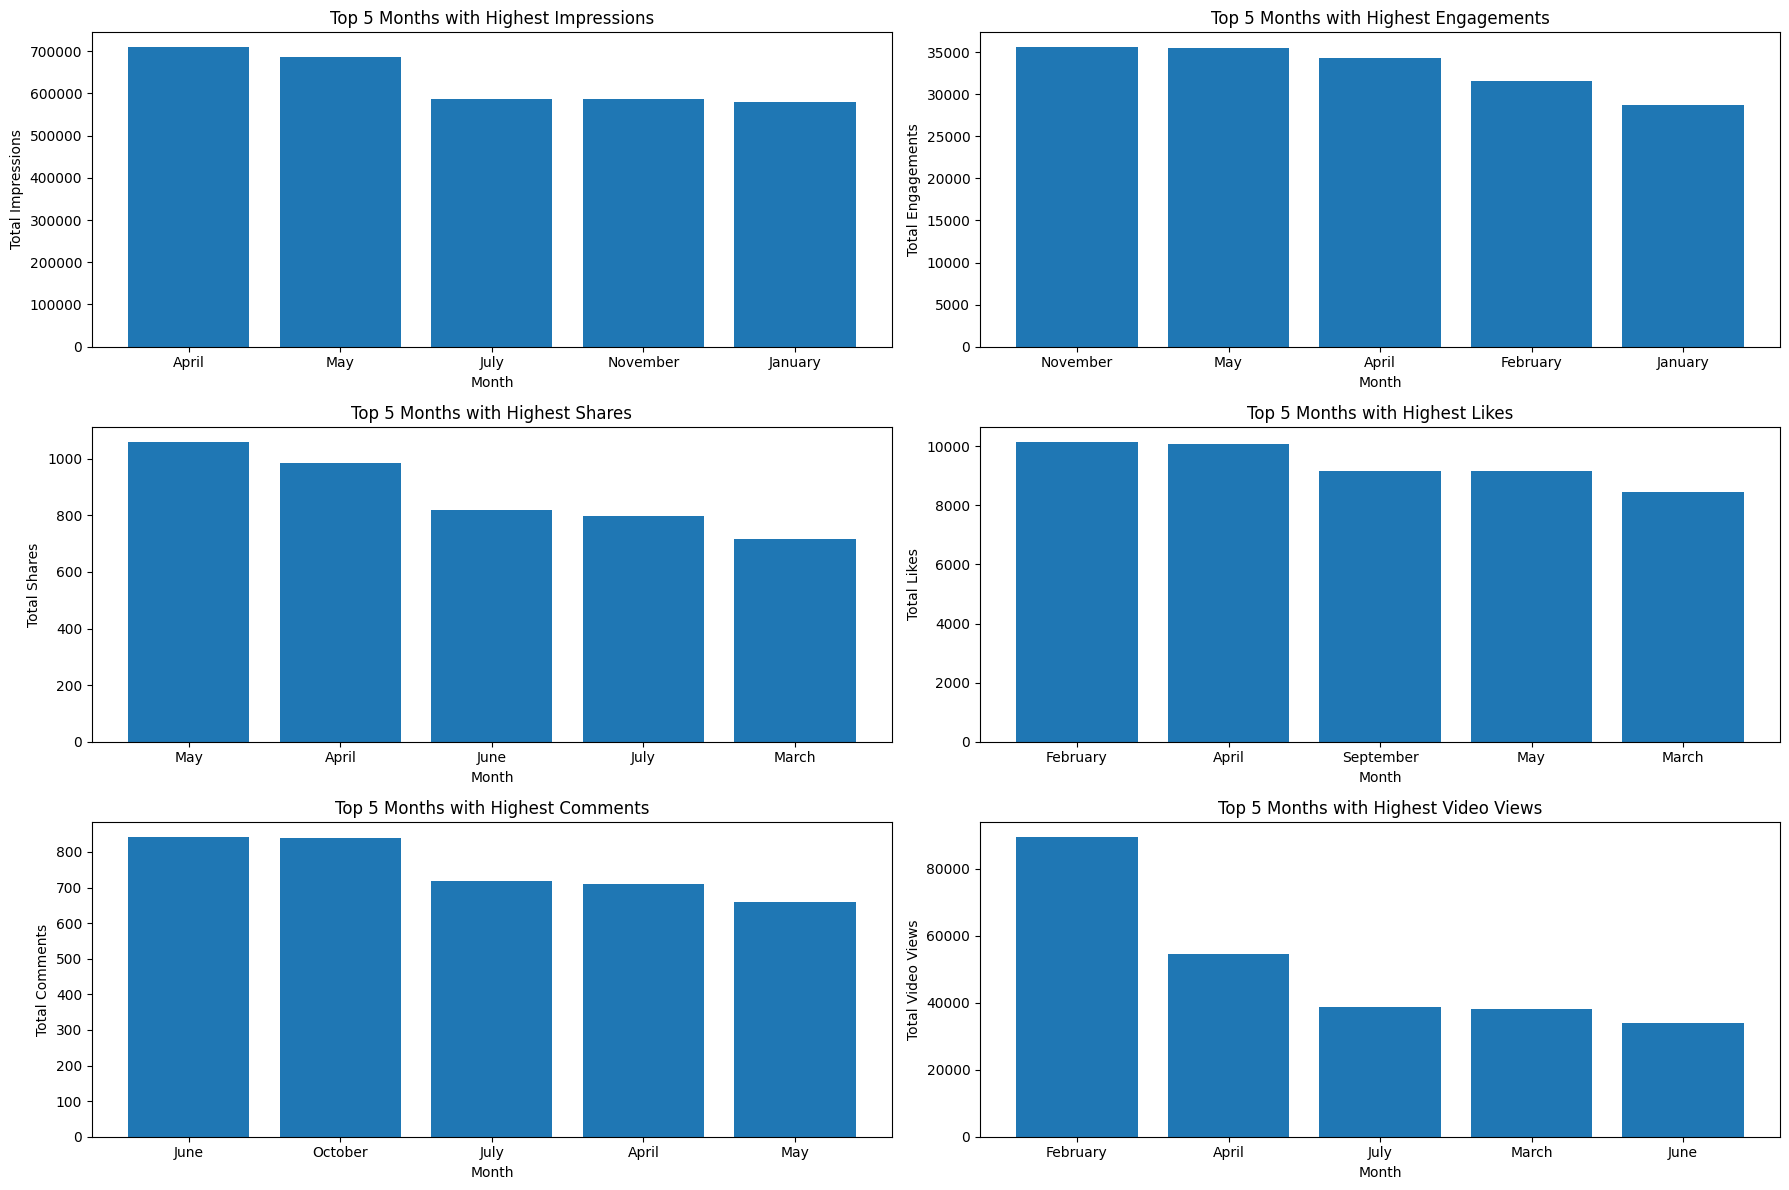

In [23]:
monthly_data = data.groupby('PostMonth')[['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']].sum()

sorted_monthly_data = {}
for metric in ['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']:
    sorted_monthly_data[metric] = monthly_data.sort_values(by=metric, ascending=False)

top_5_months = {}
for metric in ['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']:
    top_5_months[metric] = sorted_monthly_data[metric].head(5)

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 12))

for i, metric in enumerate(['Impressions', 'Engagements', 'Shares','Likes','Comments','Video Views']):
    ax = axes[i // 2, i % 2]
    ax.bar(top_5_months[metric].index, top_5_months[metric][metric])
    ax.set_title(f'Top 5 Months with Highest {metric}')
    ax.set_xlabel('Month')
    ax.set_ylabel(f'Total {metric}')

plt.tight_layout()

plt.show()

Post Duration Analysis

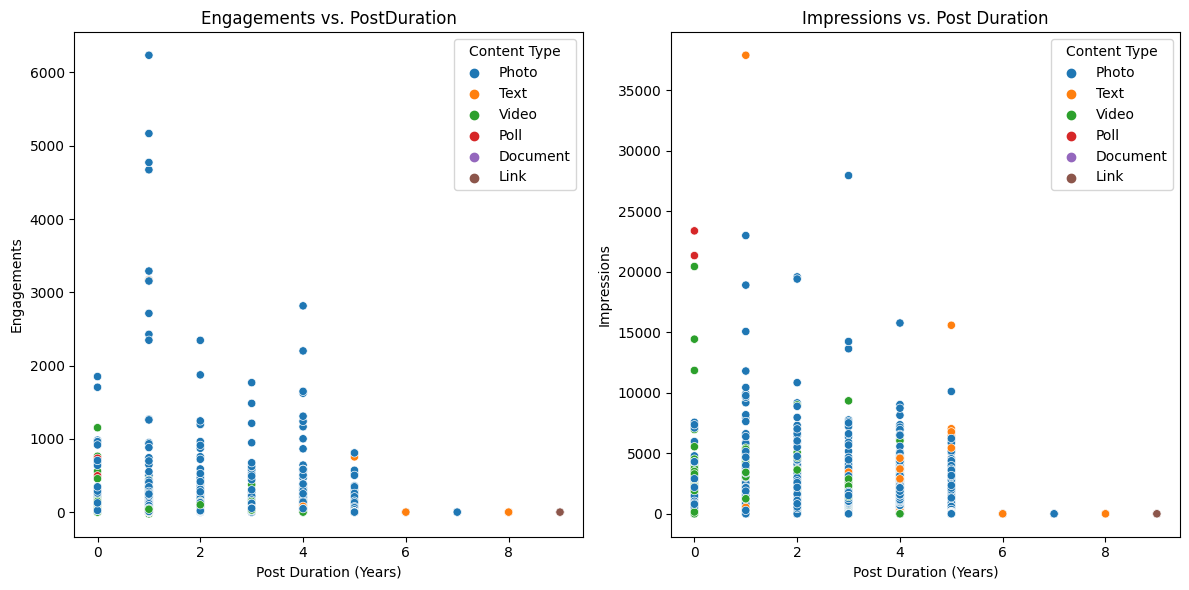

In [ ]:
plt.figure(figsize=(12, 6))

ax1 = plt.subplot(1, 2, 1) 
sns.scatterplot(data=data, x='PostDuration', y='Engagements', hue='Content Type', ax=ax1)
ax1.set_xlabel('Post Duration (Years)')
ax1.set_ylabel('Engagements')
ax1.set_title('Engagements vs. PostDuration')

ax2 = plt.subplot(1, 2, 2) # Right subplot for Impressions
sns.scatterplot(data=data, x='PostDuration', y='Impressions', hue='Content Type', ax=ax2)
ax2.set_xlabel('Post Duration (Years)')
ax2.set_ylabel('Impressions')
ax2.set_title('Impressions vs. Post Duration')

plt.tight_layout()
plt.show()

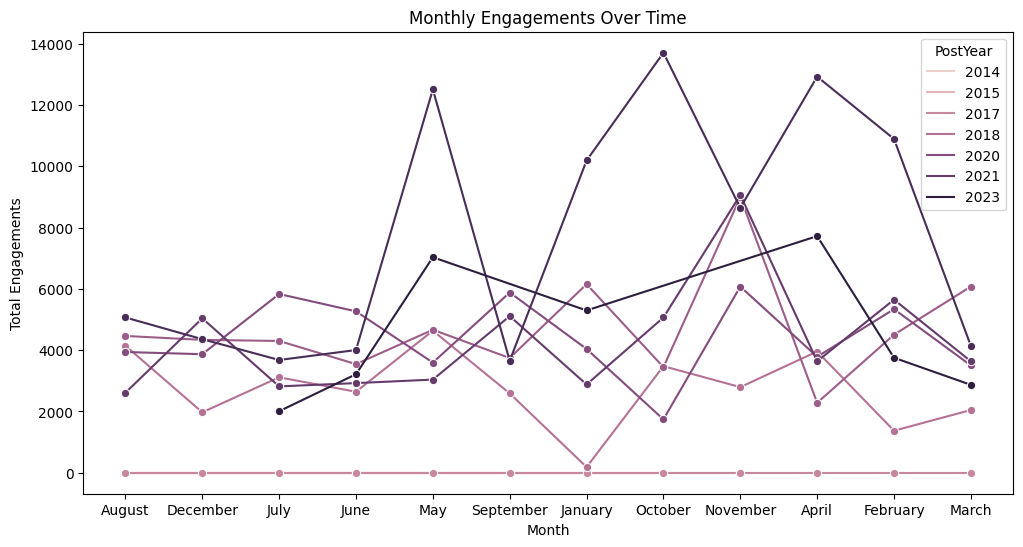

In [ ]:
monthly_engagement = data.groupby(['PostYear', 'PostMonth'])['Engagements'].sum().reset_index()
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_engagement, x='PostMonth', y='Engagements', hue='PostYear', marker='o')
plt.xlabel('Month')
plt.ylabel('Total Engagements')
plt.title('Monthly Engagements Over Time')
plt.show()